# Ames Housing Data Preprocessing and Feature Engineering

This project aims to predict housing prices in Ames, Iowa based on the famous Ames Iowa Housing Dataset from the Ames City Assessor's Office, made available by Dean De Cock of Truman University in 2011. Professor De Cock's original paper can be found [here.](http://jse.amstat.org/v19n3/decock.pdf)

Presentation Slides for this project can be found [here.](https://www.beautiful.ai/player/-N4J5UYshyuRtwl5G4I7)

This notebook includes python code for data extraction, cleaning and transformation. Model Fitting and Analysis code can be found in the Ames_Models notebook.

# Sections and steps

- <a href="#IMP">Reading in Data</a><br>
- <a href="#FEN">Feature Engineering</a><br>
    - <a href="#SP">Second Pass - Analysis</a><br>
    - <a href="#SP"> Summary of Feature Engineering </a><br>
- <a href="#PRE">Preparing Data for Models</a><br>
    - Linear Models
        -dummify categorical variables
    - Non Linear Models
        -label encode categorical variables
    - All Models
        -split train and validate datasets
        -standardize the numerical variables
- <a href="#EXP">Exporting Cleaned Datasets</a><br>

<p><a name="IMP"></a></p>

## Importing Packages, Reading in Data

In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

#### Importing helper module

In [2]:
#importing helper functions from helper module
from helper_module import * #look_cat, look_num, look_cat2, look_num2

#### Reading in train data

In [3]:
train = pd.read_csv('./data/raw/train.csv')
train.head()
#train.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read in Ames Housing Train Data - Shape: {train.shape}")

Read in Ames Housing Train Data - Shape: (1460, 81)


#### Reading in test data

In [4]:
test = pd.read_csv('./data/raw/test.csv')
test.head()
#test.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read in Ames Housing Test Data - Shape: {test.shape}")

Read in Ames Housing Test Data - Shape: (1459, 80)


<p><a name="FP"></a></p>

## Independent Variables Analysis

### Looking into Multicollinearity among Features

In [1]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, cmap = 'coolwarm', square=True);

NameError: name 'train' is not defined

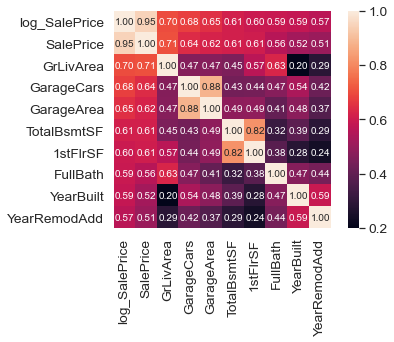

In [20]:
#log_saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'log_SalePrice')['log_SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap = 'coolwarm' cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

###### First Pass Categorical Variable Findings
1. Variables that are candidates for further ANOVA and potential condensing
    - MSSubClass -> 
    - LandContour -> could be binarized, very small effect size
    - Lot Config -> mostly inside, but culdesac has mean higher log sp
    - Neighborhood -> high effect size, but too many categories
    - BldgType -> mostly one fam
    - Roof Style - > mostly gable
    - RoofMatl -> mostly compshngl
    - Exterior1st
    - Exterior2nd
    - ExterCond
    - Functional -> mostly typical, but some major
    - SaleCondition -> drop Abnormal/Family/Alloca/AdjLand and only keep normal and partial (new) sales?
3. Variables that are candidates to be dropped
    - LandSlope -> insig ANOVA
    - BsmtFinType2 -> insig ANOVA
4. Variables to be adjusted
    - MSZoning -> remove 10 obs that are commercial
    - Condition 1 -> maybe split into normal, pos and negative condition
    - Same for Condition 2 -> possible to drop, all but 15 obs are normal
    - House Style -> maybe create 2nd floor or not variable
5. Variables to keep (high effect sizes)
    - MasVnrType, ExterQual, Foundation, BsmtQual, BsmtExposure, BsmtFinType1, HeatingQC, CentralAir, Kitchen Qual, FireplaceQu, GarageType, GarageFinish, SaleType

###### First Pass Numerical Variable Findings
1. Variables that are candidates to be dropped
    - BsmtFinSF2 (r of -0.003)
    - LowQualFinSF
    - 3SsnPorch (r = 0.06)
    - PoolArea(r = 0.043)
2. Variables to be adjusted
    - LotFrontage has two potential outliers (lot frontage > 300)
    - Lot Area has some outliers too (lot area > 40000)
    - OverallQual, Overall Cond, YrSold, should be ordinal variables
    - MasVnrArea has a potential outlier
3. Variables to keep (high effect sizes)
    - LotFrontage, LotArea , OverallQual, Year Built, Year RemodAdd, MasVnrArea, BsmtFinSF1, BsmtUnfSF, Total BsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF
6. Other Notes

<p><a name="SP"></a></p>

## Second Pass Looking at Independent Variables

### Pearson's correlation for numerical variables

Now that we have addressed all missing data, and removed outliers, we can run some bivariate statistical tests to help us glean which features to select.

In [179]:
#pearson's correlation
lose = []
def my_pear(numvar_list):
    keep = []
    for item in numvar_list:
        corr = pearsonr(train[item], train['log_SalePrice'])
        print('Pearsons correlation for ' + item + ' (r):', round(corr[0],3))
        if abs(round(corr[0],3)) > .15:
            keep.append(item)
    return keep

In [180]:
num_var = train.select_dtypes('number').columns.tolist()

In [181]:
print('Starting with ' + str(len(num_var)) + ' numerical variables.')

Starting with 32 numerical variables.


In [182]:
num_var = my_pear(num_var)

Pearsons correlation for Id (r): -0.017
Pearsons correlation for LotFrontage (r): 0.33
Pearsons correlation for LotArea (r): 0.366
Pearsons correlation for OverallQual (r): 0.821
Pearsons correlation for OverallCond (r): -0.037
Pearsons correlation for MasVnrArea (r): 0.427
Pearsons correlation for BsmtFinSF1 (r): 0.379
Pearsons correlation for BsmtFinSF2 (r): 0.0
Pearsons correlation for BsmtUnfSF (r): 0.226
Pearsons correlation for TotalBsmtSF (r): 0.639
Pearsons correlation for 1stFlrSF (r): 0.611
Pearsons correlation for 2ndFlrSF (r): 0.31
Pearsons correlation for LowQualFinSF (r): -0.037
Pearsons correlation for GrLivArea (r): 0.719
Pearsons correlation for BedroomAbvGr (r): 0.206
Pearsons correlation for KitchenAbvGr (r): -0.147
Pearsons correlation for TotRmsAbvGrd (r): 0.536
Pearsons correlation for Fireplaces (r): 0.483
Pearsons correlation for GarageCars (r): 0.682
Pearsons correlation for WoodDeckSF (r): 0.331
Pearsons correlation for OpenPorchSF (r): 0.329
Pearsons correlat

In [136]:
print('Reducing to ' + str(len(num_var)) + ' numerical variables.')

Reducing to 22 numerical variables.


### ANOVA and condensing for categorical variables

In [226]:
#selecting categorical variables
cat_var = train.select_dtypes('O').columns.tolist()

In [240]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def my_anova(catvar_list):
    C_list = []
    keep = []
    for item in catvar_list:
        temp_ = 'log_SalePrice ~ C(' + item + ')'
        model = ols(temp_, data = train).fit()
        anova_tbl = sm.stats.anova_lm(model, typ=2)
        effect_size = anova_tbl['sum_sq'][0]/(anova_tbl['sum_sq'][0]+anova_tbl['sum_sq'][1])
        
        p_val = round(anova_tbl['PR(>F)'][0], 5)
        print('ANOVA p-val for classes of ' + item + ' is', p_val, ' and ', round(effect_size, 5))
        if p_val <= 0.01:
            keep.append(item)
    return keep 

In [241]:
len(cat_var)

41

In [242]:
cat_var = my_anova(cat_var)

ANOVA p-val for classes of MSSubClass is 0.0  and  0.33424
ANOVA p-val for classes of MSZoning is 0.0  and  0.17764
ANOVA p-val for classes of Street is 0.00573  and  0.00526
ANOVA p-val for classes of LotShape is 0.0  and  0.08291
ANOVA p-val for classes of LandContour is 0.0  and  0.0251
ANOVA p-val for classes of LotConfig is 0.0  and  0.02253
ANOVA p-val for classes of Neighborhood is 0.0  and  0.56996
ANOVA p-val for classes of Condition1 is 0.0  and  0.04278
ANOVA p-val for classes of Condition2 is 0.00673  and  0.01342
ANOVA p-val for classes of BldgType is 0.0  and  0.0414
ANOVA p-val for classes of HouseStyle is 0.0  and  0.10352
ANOVA p-val for classes of RoofStyle is 0.0  and  0.04263
ANOVA p-val for classes of RoofMatl is 0.01934  and  0.01041
ANOVA p-val for classes of Exterior1st is 0.0  and  0.19076
ANOVA p-val for classes of Exterior2nd is 0.0  and  0.17566
ANOVA p-val for classes of MasVnrType is 0.0  and  0.19625
ANOVA p-val for classes of ExterQual is 0.0  and  0.470

In [243]:
len(cat_var)

40

Based on our first pass, and familiarization with the data, the independent variables in this dataset fall broadly into these 'buckets':
- Land and Exterior - neighborhood, lot and land characteristics
- House Quality, Construction and Utilities- year built, types of materials used and quality
- Indoor Areas
- Basement
- Semi-Indoor Areas - Garage, Porches, Pool, Fence
- Sale Information - month, year, type of sale etc

We will look at the categorical variables in each of these buckets individually and adjust features.

In [244]:
#initializing an iterator to help bucket variables
call_var = iter(cat_var)
next(call_var)

'MSSubClass'

In [287]:
next(call_var)

StopIteration: 

In [271]:
#Bucketing variables into lists
Location = ['MSSubClass','MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'NeighbQual']
HouseQual = ['BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical']
Basement = ['BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1','BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2']
IndoorA = ['KitchenQual', 'Functional', 'FireplaceQu']
GaragePlus = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','PavedDrive','Fence']
SaleInfo = ['MoSold','SaleType', 'SaleCondition']

In [202]:
#Sanity Check to make sure I got all the variables, minus our dependent variable - looking for 80
bucketlist = [Location, HouseQual, Basement, IndoorA, GaragePlus, SaleInfo]
temp_ = 0
for L in bucketlist:
    temp_ += len(L)
print(temp_)
print(len(cat_var))

46
43


In [295]:
#location
df_l = train[Location + ['log_SalePrice']]
#HouseQual
df_h = train[HouseQual + ['log_SalePrice']]
#Basement
df_b = train[Basement + ['log_SalePrice']]
#IndoorA
df_i = train[IndoorA + ['log_SalePrice']]
#GaragePlus
df_g = train[GaragePlus + ['log_SalePrice']]
#Sale Info
df_s = train[SaleInfo + ['log_SalePrice']]

### Location

In [342]:
l = my_anova(df_l.columns)

ANOVA p-val for classes of MSSubClass is 0.0  and  0.33424
ANOVA p-val for classes of MSZoning is 0.0  and  0.17764
ANOVA p-val for classes of Street is 0.00573  and  0.00526
ANOVA p-val for classes of LotShape is 0.0  and  0.08291
ANOVA p-val for classes of LandContour is 0.0  and  0.0251
ANOVA p-val for classes of LotConfig is 0.0  and  0.02253
ANOVA p-val for classes of Neighborhood is 0.0  and  0.56996
ANOVA p-val for classes of Condition1 is 0.0  and  0.04278
ANOVA p-val for classes of Condition2 is 0.00673  and  0.01342
ANOVA p-val for classes of NeighbQual is 0.0  and  0.2354
ANOVA p-val for classes of log_SalePrice is 0.0  and  1.0


In [344]:
l

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'NeighbQual',
 'log_SalePrice']

In [343]:
view_cat = look_cat(l)

In [330]:
next(view_cat)

StopIteration: 

#Takeaways from second pass on Location
- Remove 10 observations that are MSZoning = C (commercial instead of residential)

In [331]:
#Removing MSZoning = C observations
obs_to_drop += np.where(train['MSZoning'] == 'C (all)')[0].tolist()

In [332]:
col_to_drop = ['Street', 'Neighborhood', 'Condition 2']

In [333]:
#Binarizing LotShape Variable
train['LotShape2'] = np.nan
train.loc[train.LotShape != 'Reg', 'LotShape2'] = 0
train.loc[train.LotShape == 'Reg', 'LotShape2'] = 1

#Binarizing LandContour Variable
train['LandContour2'] = np.nan
train.loc[train.LandContour != 'Lvl', 'LandContour2'] = 0
train.loc[train.LandContour == 'Lvl', 'LandContour2'] = 1

In [334]:
pd.set_option('display.max_columns',None)
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_SalePrice,AgeHome,YrsSnRmdl,BthrmAbvGrd,BthrmBsmt,NeighbQual,LotShape2,LandContour2
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,12.247694,5,5,2.5,1,TA,1.0,1.0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,12.109011,31,31,2.0,1,Ex,1.0,1.0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,12.317167,7,6,2.5,1,TA,0.0,1.0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,11.849398,91,36,1.0,1,Ex,0.0,1.0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,12.429216,8,8,2.5,1,Ex,0.0,1.0
5,6,50,RL,85.0,14115,Pave,IR1,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,TA,TA,Y,40,30,0,320,0,0,1,10,2009,WD,Normal,143000,11.870600,16,14,1.5,1,Po,0.0,1.0
6,7,20,RL,75.0,10084,Pave,Reg,Lvl,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000,12.634603,3,2,2.0,1,Gd,1.0,1.0
7,8,60,RL,80.0,10382,Pave,IR1,Lvl,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,TA,TA,Y,235,204,228,0,0,0,0,11,2009,WD,Normal,200000,12.206073,36,36,2.5,1,Gd,0.0,1.0
8,9,50,RM,51.0,6120,Pave,Reg,Lvl,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,Fa,TA,Y,90,0,205,0,0,0,0,4,2008,WD,Abnorml,129900,11.774520,77,58,2.0,0,TA,1.0,1.0
9,10,190,RL,50.0,7420,Pave,Reg,Lvl,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,2,2,TA,5,Typ,2,TA,Attchd,1939.0,RFn,1,Gd,TA,Y,0,4,0,0,0,0,0,1,2008,WD,Normal,118000,11.678440,69,58,1.0,1,Fa,1.0,1.0


In [335]:
#Checking with ANOVA
my_anova(['LotShape', 'LotShape2', 'LandContour', 'LandContour2'])

ANOVA p-val for classes of LotShape is 0.0  and  0.08291
ANOVA p-val for classes of LotShape2 is 0.0  and  0.07939
ANOVA p-val for classes of LandContour is 0.0  and  0.0251
ANOVA p-val for classes of LandContour2 is 0.91806  and  1e-05


['LotShape', 'LotShape2', 'LandContour']

In [336]:
col_to_drop += ['LotShape']

In [341]:
print(obs_to_drop)
col_to_drop

[30, 88, 93, 491, 552, 704, 805, 909, 1054, 1271, 30, 88, 93, 491, 552, 704, 805, 909, 1054, 1271]


['Street', 'Neighborhood', 'Condition 2', 'LotShape']

## House Quality

In [102]:
df_h = train[HouseQual + ['log_SalePrice']]
df_h.columns

Index(['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'AgeHome',
       'YrsSnRmdl', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'log_SalePrice'],
      dtype='object')

In [104]:
#Double Checking missing Values
#df_h.isna().sum()

In [106]:
cat_var = df_h.select_dtypes('O').columns.tolist()
num_var = df_h.select_dtypes('number').columns.tolist()

In [ ]:
#view_cat = look_cat(cat_var)
view_num = look_num2(num_var)

In [111]:
num_var

['OverallQual',
 'OverallCond',
 'AgeHome',
 'YrsSnRmdl',
 'MasVnrArea',
 'log_SalePrice']

In [118]:
def my_pear(numvar_list):
    keep = []
    for item in numvar_list:
        corr = pearsonr(train[item], train['log_SalePrice'])
        print('Pearsons correlation for ' + item + ' (r):', round(corr[0],3))
        if abs(round(corr[0],3)) > .15:
            keep.append(item)
    return keep

In [121]:
my_pear(num_var)

Pearsons correlation for OverallQual (r): 0.821
Pearsons correlation for OverallCond (r): -0.037
Pearsons correlation for AgeHome (r): -0.593
Pearsons correlation for YrsSnRmdl (r): -0.575
Pearsons correlation for MasVnrArea (r): 0.427
Pearsons correlation for log_SalePrice (r): 1.0


['OverallQual', 'AgeHome', 'YrsSnRmdl', 'MasVnrArea', 'log_SalePrice']

## Basement

## IndoorA

## GaragePlus

In [ ]:
df_g = train[Garage]
print(df_g.columns)

#Missing Values
df_g.isna().sum()

From Data Description -> Na is No Garage, so we will impute 

## PorchPlus


In [ ]:
df_pp = train[PorchPlus]
df_pp.columns

In [ ]:
#Missing Values
df_sale.isna().sum()

In [ ]:
#correlation matrix
corrmat = df_pp.corr()
f, ax = plt.subplots(figsize=(6, 8))

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'log_SalePrice')['log_SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Sale Info

In [ ]:
df_sale = train[SaleInfo]

In [ ]:
df_sale.head()

In [ ]:
#Missing Values
df_sale.isna().sum()

In [ ]:
#correlation matrix
corrmat = df_sale.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
## Looking into number of missing values
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Number Missing', 'Percent Missing'])
missing_data.head(29)

In [ ]:
train['PoolQC'].isnull().sum()

In [ ]:
#Making a table with the number and percentages of missing observations
num = train.isnull().sum().sort_values(ascending=False)
pct = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
df_md = pd.concat([num, pct], axis=1, keys=['Number', 'Percent'])

#filtering for only the variables where there is 1 or more missing observations
df_md.columns
df_md.loc[df_md.Number > 0]

### Summary of Data Cleaning

#### Data Imputation
PoolQC --> 1453 NA imputed to 0 for no pool

#### Handling Outliers and Anomalies

#### Categorical Features - box plot, bar plot, ANOVA

#### Quantitative Features - correlation matrix, histogram

#### Looking into Multicollinearity

In [ ]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Dropped Features

#### Columns with no meaningful difference between categories

#### Low correlation

#### Multicollinearity

#### Administrative Columns

<p><a name="PRE"></a></p>

## Preprocessing Data for Models

### Linear Models
#### Dummification of Categorical Variables

#### Testing Assumptions for Linear Models

### Non Linear Models
#### Label Encoding of Categorical Variables

### All Models
#### Standardization of numerical variables
#### Split train and validate datasets

<p><a name="EXP"></a></p>

## Exporting Cleaned Datasets

In [ ]:
train.to_csv('./data/cleaned/train_c.csv')